In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "all_z"
key = "lambda"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  6.00it/s]

14it [00:00,  8.41it/s]

23it [00:00, 11.55it/s]

32it [00:00, 15.59it/s]

42it [00:00, 20.85it/s]

55it [00:00, 27.85it/s]

68it [00:00, 36.38it/s]

82it [00:00, 46.44it/s]

95it [00:00, 57.38it/s]

108it [00:01, 68.79it/s]

120it [00:01, 75.69it/s]

133it [00:01, 86.31it/s]

145it [00:01, 93.80it/s]

159it [00:01, 102.61it/s]

172it [00:01, 108.34it/s]

185it [00:01, 113.22it/s]

198it [00:01, 112.13it/s]

210it [00:01, 104.99it/s]

222it [00:02, 108.36it/s]

236it [00:02, 114.73it/s]

248it [00:02, 116.14it/s]

260it [00:02, 110.91it/s]

273it [00:02, 116.02it/s]

285it [00:02, 114.71it/s]

297it [00:02, 113.67it/s]

309it [00:02, 101.59it/s]

320it [00:03, 92.27it/s] 

333it [00:03, 100.90it/s]

346it [00:03, 107.58it/s]

360it [00:03, 113.63it/s]

372it [00:03, 114.32it/s]

384it [00:03, 109.39it/s]

397it [00:03, 114.71it/s]

411it [00:03, 119.20it/s]

424it [00:03, 121.55it/s]

438it [00:03, 124.20it/s]

452it [00:04, 126.51it/s]

465it [00:04, 126.77it/s]

479it [00:04, 128.37it/s]

492it [00:04, 128.19it/s]

506it [00:04, 128.48it/s]

519it [00:04, 107.85it/s]

532it [00:04, 112.85it/s]

545it [00:04, 116.61it/s]

558it [00:04, 115.70it/s]

571it [00:05, 119.64it/s]

584it [00:05, 122.31it/s]

597it [00:05, 124.36it/s]

611it [00:05, 126.32it/s]

624it [00:05, 127.24it/s]

637it [00:05, 127.97it/s]

650it [00:05, 128.33it/s]

664it [00:05, 129.16it/s]

677it [00:05, 113.78it/s]

690it [00:06, 117.81it/s]

704it [00:06, 121.30it/s]

717it [00:06, 112.98it/s]

731it [00:06, 118.32it/s]

744it [00:06, 119.81it/s]

758it [00:06, 123.01it/s]

771it [00:06, 120.74it/s]

784it [00:06, 122.18it/s]

797it [00:06, 122.96it/s]

810it [00:07, 123.84it/s]

823it [00:07, 124.96it/s]

837it [00:07, 126.55it/s]

850it [00:07, 121.29it/s]

863it [00:07, 110.29it/s]

876it [00:07, 114.24it/s]

889it [00:07, 117.03it/s]

902it [00:07, 118.22it/s]

914it [00:07, 114.54it/s]

926it [00:08, 100.76it/s]

938it [00:08, 103.99it/s]

951it [00:08, 108.92it/s]

963it [00:08, 111.87it/s]

976it [00:08, 115.81it/s]

989it [00:08, 118.24it/s]

1002it [00:08, 120.82it/s]

1015it [00:08, 117.35it/s]

1028it [00:08, 119.99it/s]

1041it [00:09, 119.81it/s]

1054it [00:09, 119.23it/s]

1066it [00:09, 94.24it/s] 

1077it [00:09, 91.77it/s]

1087it [00:09, 83.25it/s]

1097it [00:09, 87.25it/s]

1108it [00:09, 92.55it/s]

1121it [00:09, 101.10it/s]

1134it [00:10, 106.41it/s]

1147it [00:10, 110.84it/s]

1161it [00:10, 116.11it/s]

1174it [00:10, 119.34it/s]

1187it [00:10, 121.19it/s]

1200it [00:10, 117.39it/s]

1212it [00:10, 102.25it/s]

1223it [00:10, 87.46it/s] 

1233it [00:11, 76.23it/s]

1242it [00:11, 70.62it/s]

1250it [00:11, 67.52it/s]

1258it [00:11, 65.44it/s]

1265it [00:11, 64.01it/s]

1272it [00:11, 62.15it/s]

1279it [00:11, 60.26it/s]

1286it [00:11, 60.33it/s]

1293it [00:12, 59.15it/s]

1300it [00:12, 59.71it/s]

1307it [00:12, 55.85it/s]

1313it [00:12, 56.58it/s]

1319it [00:12, 55.95it/s]

1325it [00:12, 56.50it/s]

1331it [00:12, 57.02it/s]

1337it [00:12, 57.67it/s]

1347it [00:12, 65.23it/s]

1360it [00:13, 76.28it/s]

1373it [00:13, 86.17it/s]

1383it [00:13, 84.00it/s]

1397it [00:13, 94.10it/s]

1410it [00:13, 102.45it/s]

1423it [00:13, 108.81it/s]

1432it [00:13, 104.94it/s]


0it [00:00, ?it/s]

13it [00:00, 128.38it/s]

Number of empty sat catalogs is 0


27it [00:00, 129.74it/s]

41it [00:00, 131.66it/s]

54it [00:00, 128.59it/s]

64it [00:00, 112.95it/s]

76it [00:00, 114.37it/s]

87it [00:00, 104.29it/s]

97it [00:00, 99.01it/s] 

111it [00:00, 107.58it/s]

125it [00:01, 115.34it/s]

137it [00:01, 109.73it/s]

151it [00:01, 116.90it/s]

165it [00:01, 121.22it/s]

179it [00:01, 123.98it/s]

193it [00:01, 127.23it/s]

207it [00:01, 129.16it/s]

221it [00:01, 114.59it/s]

235it [00:01, 120.44it/s]

249it [00:02, 125.11it/s]

263it [00:02, 128.09it/s]

277it [00:02, 130.64it/s]

291it [00:02, 121.35it/s]

304it [00:02, 121.84it/s]

317it [00:02, 113.27it/s]

331it [00:02, 120.10it/s]

345it [00:02, 123.28it/s]

358it [00:02, 114.06it/s]

372it [00:03, 120.09it/s]

386it [00:03, 124.63it/s]

400it [00:03, 127.32it/s]

414it [00:03, 129.97it/s]

428it [00:03, 129.86it/s]

442it [00:03, 128.64it/s]

456it [00:03, 131.25it/s]

470it [00:03, 131.48it/s]

484it [00:03, 128.88it/s]

497it [00:04, 110.05it/s]

510it [00:04, 113.93it/s]

524it [00:04, 119.89it/s]

537it [00:04, 122.27it/s]

551it [00:04, 126.41it/s]

565it [00:04, 129.16it/s]

579it [00:04, 130.80it/s]

593it [00:04, 133.28it/s]

607it [00:04, 134.89it/s]

621it [00:05, 133.56it/s]

635it [00:05, 133.89it/s]

649it [00:05, 134.51it/s]

663it [00:05, 135.02it/s]

677it [00:05, 134.74it/s]

691it [00:05, 136.01it/s]

705it [00:05, 137.11it/s]

719it [00:05, 137.04it/s]

733it [00:05, 137.31it/s]

747it [00:05, 136.91it/s]

761it [00:06, 136.65it/s]

775it [00:06, 132.21it/s]

789it [00:06, 132.94it/s]

803it [00:06, 132.94it/s]

817it [00:06, 112.52it/s]

829it [00:06, 98.21it/s] 

843it [00:06, 106.39it/s]

855it [00:06, 101.09it/s]

868it [00:07, 108.09it/s]

883it [00:07, 116.10it/s]

897it [00:07, 121.41it/s]

911it [00:07, 125.03it/s]

925it [00:07, 127.13it/s]

939it [00:07, 130.27it/s]

953it [00:07, 125.58it/s]

967it [00:07, 129.21it/s]

981it [00:07, 131.41it/s]

995it [00:07, 132.86it/s]

1009it [00:08, 132.64it/s]

1023it [00:08, 122.34it/s]

1037it [00:08, 126.50it/s]

1051it [00:08, 128.44it/s]

1064it [00:08, 128.19it/s]

1077it [00:08, 124.28it/s]

1090it [00:08, 123.74it/s]

1103it [00:08, 124.58it/s]

1116it [00:08, 122.81it/s]

1130it [00:09, 126.49it/s]

1144it [00:09, 129.23it/s]

1158it [00:09, 130.98it/s]

1172it [00:09, 130.98it/s]

1186it [00:09, 131.84it/s]

1200it [00:09, 133.71it/s]

1214it [00:09, 134.42it/s]

1228it [00:09, 135.88it/s]

1242it [00:09, 136.00it/s]

1256it [00:10, 136.68it/s]

1270it [00:10, 136.83it/s]

1284it [00:10, 135.44it/s]

1298it [00:10, 135.47it/s]

1312it [00:10, 118.33it/s]

1325it [00:10, 106.31it/s]

1337it [00:10, 105.11it/s]

1348it [00:10, 99.36it/s] 

1359it [00:10, 95.14it/s]

1372it [00:11, 102.63it/s]

1383it [00:11, 104.52it/s]

1396it [00:11, 110.02it/s]

1409it [00:11, 114.27it/s]

1421it [00:11, 105.82it/s]

1432it [00:11, 123.11it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

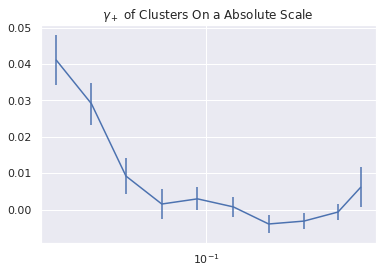

Aggregated xi:
[ -9.1159 -12.5299  -6.4698  -1.7039  -5.822   -2.1743  17.0118  16.4851
   3.5706  -4.6139]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -960.5094 -1660.4938 -2381.6983 -3259.5196 -4797.6824 -5805.1601
 -6282.1845 -5141.1614 -2773.7882  -169.741 ]
------------------------------------------------------------------------------
Aggregated npairs:
[ 222.  431.  703. 1122. 1979. 2992. 4289. 5194. 5234.  755.]
------------------------------------------------------------------------------
Mean xi:
[-0.0411 -0.0291 -0.0092 -0.0015 -0.0029 -0.0007  0.004   0.0032  0.0007
 -0.0061]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3266 -3.8527 -3.3879 -2.9051 -2.4243 -1.9402 -1.4647 -0.9898 -0.53
 -0.2248]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

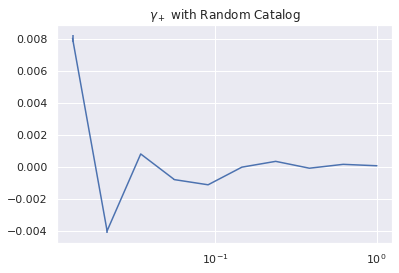

[ 8.0614e-03 -4.0169e-03  8.0985e-04 -8.0003e-04 -1.1234e-03 -1.6914e-05
  3.4635e-04 -8.3508e-05  1.5886e-04  6.9678e-05]
[-2.1303e-04  1.0615e-04 -2.1401e-05  2.1141e-05  2.9686e-05  4.4697e-07
 -9.1527e-06  2.2068e-06 -4.1980e-06 -1.8413e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

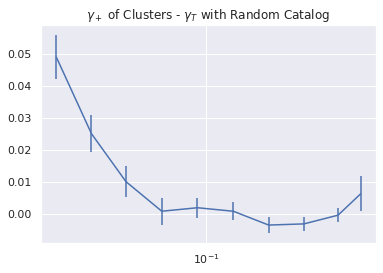

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

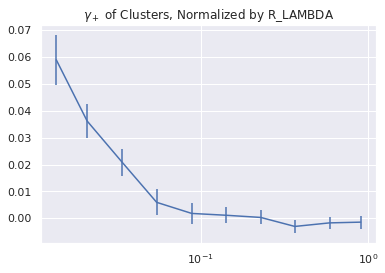

Aggregated xi:
[ -5.8329 -10.0925 -11.1382  -4.8179  -2.5111  -2.5781  -1.124   13.9473
   9.2314   5.8886]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -424.8205 -1078.7646 -1815.8747 -2357.3223 -3345.1597 -4402.6546
 -4975.5146 -4671.1406 -2900.6064  -429.6951]
------------------------------------------------------------------------------
Aggregated npairs:
[  99.  279.  537.  810. 1378. 2251. 3366. 4630. 5454. 4157.]
------------------------------------------------------------------------------
Mean xi:
[-0.0589 -0.0362 -0.0207 -0.0059 -0.0018 -0.0011 -0.0003  0.003   0.0017
  0.0014]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2911 -3.8665 -3.3815 -2.9103 -2.4275 -1.9559 -1.4782 -1.0089 -0.5318
 -0.1034]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)